## PREDICTING FINANCIAL WELL-BEING OF SMALL BUSINESSES

Across Southern Africa, small and medium-sized enterprises (SMEs) are vital to employment, innovation, and economic growth, yet many remain financially fragile and excluded from formal financial systems. Limited access to credit, unstable cash flow, and exposure to shocks such as illness or climate events make them vulnerable. Traditional measures like revenue or profit do not capture an SME’s true financial well-being. To support SMEs more effectively, there is a need for a holistic measure that reflects resilience, savings habits, and access to finance.

This challenge introduces a data-driven Financial Health Index (FHI) for SMEs - a composite measure that classifies businesses into Low, Medium, or High financial health across four key dimensions: 
- savings and assets
- debt and repayment ability
- resilience to shocks
- access to credit and financial services. 

Derived from survey and business data, the FHI offers a more complete picture of financial stability and inclusion.

### Data Inspection

In [334]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder


In [335]:
train_data = pd.read_csv('Train.csv')
test_data = pd.read_csv('Test.csv')

In [336]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9618 entries, 0 to 9617
Data columns (total 39 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   ID                                                                9618 non-null   object 
 1   country                                                           9618 non-null   object 
 2   owner_age                                                         9618 non-null   float64
 3   attitude_stable_business_environment                              9616 non-null   object 
 4   attitude_worried_shutdown                                         9616 non-null   object 
 5   compliance_income_tax                                             9614 non-null   object 
 6   perception_insurance_doesnt_cover_losses                          9613 non-null   object 
 7   perception_cannot_afford_insuranc

In [337]:
test_data.head()

,ID,country,owner_age,attitude_stable_business_environment,attitude_worried_shutdown,compliance_income_tax,perception_insurance_doesnt_cover_losses,perception_cannot_afford_insurance,personal_income,business_expenses,...,has_loan_account,has_internet_banking,has_debit_card,future_risk_theft_stock,business_age_months,medical_insurance,funeral_insurance,motivation_make_more_money,uses_friends_family_savings,uses_informal_lender
0,ID_5EGLKX,zimbabwe,50.0,No,No,No,No,Yes,100.0,3600.0,...,NaN,NaN,NaN,No,8.0,Never had,Never had,NaN,NaN,NaN
1,ID_4AI7RE,lesotho,36.0,Yes,Yes,No,Yes,Yes,900.0,400.0,...,NaN,NaN,NaN,Yes,NaN,NaN,NaN,Yes,Used to have but don't have now,Used to have but don't have now
2,ID_V9OB3M,lesotho,25.0,Don’t know or N/A,No,No,Don't know,Don't know,5250.0,350.0,...,Used to have but don't have now,Have now,Have now,Yes,NaN,NaN,NaN,No,Never had,Used to have but don't have now
3,ID_6OI9DI,malawi,25.0,Don’t know or N/A,Yes,No,No,Yes,485000.0,10000.0,...,Never had,Never had,Never had,Yes,NaN,NaN,NaN,Yes,Have now,Never had
4,ID_H2TN8B,lesotho,47.0,No,Yes,No,Don't know,Don't know,97.0,500.0,...,Used to have but don't have now,Have now,Have now,Yes,NaN,NaN,NaN,Yes,Used to have but don't have now,Used to have but don't have now


In [338]:
print(train_data.shape)
print(test_data.shape)

(9618, 39)
(2405, 38)


### Data Processing


Now, there are only categorical and float data types

## FEATURE ENGINEERING

### 1. Savings and Assets
This dimension represents the liquidity and collateral of the SME.

Direct Effect: High levels of savings allow a business to self-fund expansion (buying new inventory or machinery) without waiting for a loan. Physical assets (vehicles, equipment) increase productivity.

Modeling Insight: In your data, features like business_turnover and keeps_financial_records are often proxies for this. A business that saves is statistically less likely to collapse during a "slow month."

#### Create profitability and margin features

In [267]:


def create_savings_assets_features_v2(df):
    df = df.copy()

    # 1. Handle Numerical NaNs BEFORE calculation
    # We use 0 for turnover/expenses so the ratio calculation doesn't fail
    temp_turnover = df['business_turnover'].fillna(0)
    temp_expenses = df['business_expenses'].fillna(0)

    # 2. Profit & Margin with CLIPPING
    # Clipping ensures one failing business doesn't have the weight of 1,000 others
    profit = temp_turnover - temp_expenses
    df['Profit_Margin'] = (profit / (temp_turnover + 1)).clip(-2, 1)

    # 3. Robust Mapping for Yes/No
    # This handles "Don't know" or Missing values as 0 (Neutral/No)
    cols_to_map = [
        'keeps_financial_records', 'has_debit_card', 
        'has_credit_card', 'offers_credit_to_customers', 
        'uses_friends_family_savings'
    ]
    
    for col in cols_to_map:
        df[col] = df[col].astype(str).str.strip().map({'Yes': 1, 'No': 0}).fillna(0)

    # 4. Component Scores
    df['Financial_discipline_score'] = (
        df['keeps_financial_records'] + 
        df['has_debit_card'] + 
        df['has_credit_card']
    ) / 3.0 # Normalize to 0-1 range

    df['formal_savings_indicator'] = 1 - df['uses_friends_family_savings']

    # 5. The Final Index (No NaNs possible here)
    df['savings_assets_index'] = (
        0.4 * df['Profit_Margin'] +
        0.3 * df['Financial_discipline_score'] +
        0.2 * df['formal_savings_indicator'] +
        0.1 * df['offers_credit_to_customers']
    )

    return df

# Apply to your data
train_data = create_savings_assets_features_v2(train_data)
test_data = create_savings_assets_features_v2(test_data)

Apply to train and val sets

### Analyze relationship with Traget

In [268]:
train_data.groupby('Target')['savings_assets_index'].mean()

Target
High      0.410537
Low       0.346701
Medium    0.357550
Name: savings_assets_index, dtype: float64

The 'savings_assets_index' behaves like this:
- Low FHI : strongly negative
- Medium FHI: moderately positive
- High FHI: highest positive

Meaning as savings and assets strength increases, financial health index increases, economically the feature aligns with FHI. Low class of -1.91 suggests that Low FHI businesses have; poor profit margins, weak financial discipline, informal savings reliance and possibly high expense ratios.

Let us employ a statistical test to test the significant difference across groups

In [269]:
from scipy.stats import f_oneway

low = train_data[train_data['Target']== 'Low']['savings_assets_index']
medium = train_data[train_data['Target']== 'Medium']['savings_assets_index']
high = train_data[train_data['Target']== 'High']['savings_assets_index']

f_stat, p_value = f_oneway(
    low, 
    medium, 
    high
)

print("F-stat:", f_stat)
print("P-value:", p_value)




F-stat: 14.33493033224489
P-value: 6.076900427654865e-07


In [270]:
np.isinf(train_data['savings_assets_index']).sum()

0

The savings_assets_index is now statstically significant feature that efectively distinguishes between Low, medium and high financial health.


In [271]:
print(low.var())
print(medium.var())
print(high.var())


0.07176785320316434
0.053517661568174536
0.04522023918358566


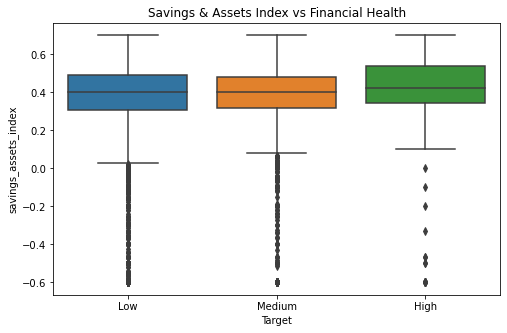

In [272]:
plt.figure(figsize=(8,5))
sns.boxplot(x='Target', y='savings_assets_index', data=train_data)
plt.title("Savings & Assets Index vs Financial Health")
plt.show()

In [273]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9618 entries, 0 to 9617
Data columns (total 43 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   ID                                                                9618 non-null   object 
 1   country                                                           9618 non-null   object 
 2   owner_age                                                         9618 non-null   float64
 3   attitude_stable_business_environment                              9616 non-null   object 
 4   attitude_worried_shutdown                                         9616 non-null   object 
 5   compliance_income_tax                                             9614 non-null   object 
 6   perception_insurance_doesnt_cover_losses                          9613 non-null   object 
 7   perception_cannot_afford_insuranc

### 2. Debt and Repayment ability

- This dimension is about the 'cost of capital' and whether the business is drowning in debt or using it to grow. Based on the dataset, we have key indicators like has loan account, uses informal lender, business expenses and current problem cashflow

- The strategy identifies good vs bad debt. 

*Repayment ability*: High expenses relative to turnover(without a loan) suggest poor efficiency. High expenses with a loan suggest a heavy repayment burden.

*Formal vs. Informal*: Informal lenders often have much higher interest rates, which directly hurts the Financial Health Index(FHI)

*Cash Flow*: A business that reports cash flow problems is statistically more likely to default on debt.

In [244]:
def create_debt_repayment_features_v2(df):
    df = df.copy()

    # 1. Map Binary Indicators and fill missing with 0 (No/Neutral)
    debt_cols = ['has_loan_account', 'uses_informal_lender', 'current_problem_cash_flow']
    for col in debt_cols:
        df[col] = df[col].astype(str).str.strip().map({'Yes': 1, 'No': 0}).fillna(0)

    # 2. Handle Numerical NaNs BEFORE ratio calculation
    # We fill with 0 so the calculation doesn't produce NaNs
    temp_expenses = df['business_expenses'].fillna(0)
    temp_turnover = df['business_turnover'].fillna(0)

    # 3. Debt Burden Ratio (Clipped to prevent "variance bombs")
    # We use (temp_turnover + 1) to avoid division by zero
    df['expense_to_turnover_ratio'] = (temp_expenses / (temp_turnover + 1)).clip(0, 5)
    
    # 4. Debt Health Score
    # Starting at 1.0 (Good) and subtracting penalties for risky behavior
    df['debt_health_score'] = 1.0
    df['debt_health_score'] -= (df['uses_informal_lender'] * 0.5)  # Informal lenders are high risk
    df['debt_health_score'] -= (df['current_problem_cash_flow'] * 0.3) # Cash flow issues
    df['debt_health_score'] -= (df['has_loan_account'] * 0.1)      # Formal debt is lower risk
    
    # 5. Final Debt & Repayment Index
    # Combining the behavioral score with the financial ratio
    df['debt_repayment_index'] = (
        0.7 * df['debt_health_score'] - 
        0.3 * df['expense_to_turnover_ratio']
    )

    return df

# Apply the rugged version
train_data = create_debt_repayment_features_v2(train_data)
test_data = create_debt_repayment_features_v2(test_data)

In [245]:
from scipy.stats import f_oneway

low = train_data[train_data['Target']== 'Low']['debt_repayment_index']
medium = train_data[train_data['Target']== 'Medium']['debt_repayment_index']
high = train_data[train_data['Target']== 'High']['debt_repayment_index']

f_stat, p_value = f_oneway(
    low, 
    medium, 
    high
)

print("F-stat:", f_stat)
print("P-value:", p_value)


F-stat: 1.3251779477633987
P-value: 0.2658041977443792


In [246]:
train_data.groupby('Target')['debt_repayment_index'].mean()

Target
High      0.448321
Low       0.431785
Medium    0.440009
Name: debt_repayment_index, dtype: float64

## 3. Resilience to shocks

Resilience is the buffer that prevents a business from collapsing when something goes wrong ( theft, illnes or a pandemic). Using our dataset, we can measure throug insurance coverage and operational stability.

- Insurance depth: Apart from looking at if the business has insuance we'll also look at the tyes of insurance they have (Medical, Funeral, Motor Vehicle). More types~high buffer.

- Perception of risk to act as a proxy for pro active mindset.

- Operational protection: 'covid_essential_service' means the business was allowed to stay open during a shock, which is a massive resilience factor.

In [326]:
def create_resilience_features(df):
    df = df.copy()

    # 1. Map Insurance Columns (Yes=1, No/NaN=0)
    # These often have missing values, so we handle them immediately
    insur_cols = [
        'has_insurance', 'medical_insurance', 
        'funeral_insurance', 'motor_vehicle_insurance'
    ]
    for col in insur_cols:
        df[col] = df[col].astype(str).str.strip().map({'Yes': 1, 'No': 0}).fillna(0)

    # 2. Insurance Depth Score
    # How many safety nets does the business have? (Max 4)
    df['insurance_depth'] = (
        df['has_insurance'] + 
        df['medical_insurance'] + 
        df['funeral_insurance'] + 
        df['motor_vehicle_insurance']
    ) / 4.0

    # 3. Map Perception & Essential Service
    df['perception_insurance_important'] = df['perception_insurance_important'].astype(str).str.strip().map({'Yes': 1, 'No': 0}).fillna(0)
    df['covid_essential_service'] = df['covid_essential_service'].astype(str).str.strip().map({'Yes': 1, 'No': 0}).fillna(0)

    # 4. Final Resilience Index
    # We give high weight to actual insurance and moderate weight to mindset/status
    df['resilience_index'] = (
        0.5 * df['insurance_depth'] +
        0.3 * df['covid_essential_service'] +
        0.2 * df['perception_insurance_important']
    )

    return df

# Apply to your data
train_data = create_resilience_features(train_data)
test_data = create_resilience_features(test_data)

In [327]:
low = train_data[train_data['Target']== 'Low']['resilience_index']
medium = train_data[train_data['Target']== 'Medium']['resilience_index']
high = train_data[train_data['Target']== 'High']['resilience_index']

f_stat, p_value = f_oneway(
    low, 
    medium, 
    high
)

print("F-stat:", f_stat)
print("P-value:", p_value)

F-stat: 184.1396049675804
P-value: 3.332050434947446e-79


## 4. Access to credit and financial services

This is about the potential and infrastructure available to the business. 

- Infrastructure : assesses if the business has the tools to receive and send money.

- Credit potential : proves that the business has already passed a bank;s vetting process.

In [249]:
def create_access_services_features(df):
    df = df.copy()

    # 1. Map Binary Indicators (Yes=1, No/NaN/Don't Know=0)
    service_cols = [
        'has_cellphone', 'has_mobile_money', 'has_internet_banking',
        'has_credit_card', 'has_loan_account', 'has_debit_card'
    ]
    for col in service_cols:
        df[col] = df[col].astype(str).str.strip().map({'Yes': 1, 'No': 0}).fillna(0)

    # 2. Infrastructure Score (The "Tools")
    # Having a phone, mobile money, and internet banking
    df['digital_infrastructure_score'] = (
        df['has_cellphone'] + 
        df['has_mobile_money'] + 
        df['has_internet_banking']
    ) / 3.0

    # 3. Formal Credit Access Score
    # Having cards and formal loan accounts
    df['formal_access_score'] = (
        df['has_credit_card'] + 
        df['has_loan_account'] + 
        df['has_debit_card']
    ) / 3.0

    # 4. Ease of Capital (Self-reported)
    # Note: 'No' to problem_sourcing_money is a positive for access
    df['easy_capital_access'] = df['problem_sourcing_money'].astype(str).str.strip().map({'No': 1, 'Yes': 0}).fillna(0)

    # 5. Final Access Index
    df['access_services_index'] = (
        0.4 * df['digital_infrastructure_score'] +
        0.4 * df['formal_access_score'] +
        0.2 * df['easy_capital_access']
    )

    return df

# Apply to your data
train_data = create_access_services_features(train_data)
test_data = create_access_services_features(test_data)

In [250]:
from scipy.stats import f_oneway

low = train_data[train_data['Target']== 'Low']['access_services_index']
medium = train_data[train_data['Target']== 'Medium']['access_services_index']
high = train_data[train_data['Target']== 'High']['access_services_index']

f_stat, p_value = f_oneway(low, medium, high)

print("F-stat:", f_stat)
print("P-value:", p_value)

F-stat: 3.6815889788505176
P-value: 0.025218434714895575


Analysing relationship between te FHI index and features like business maturity and country, we loook for "variance in the distribution." If the percentage of "High Health" SMEs changes significantly as a business gets older or across different borders, those features are strong candidates for our model.

#### *Business Maturiey vs. FHI Index*



<Figure size 720x432 with 0 Axes>

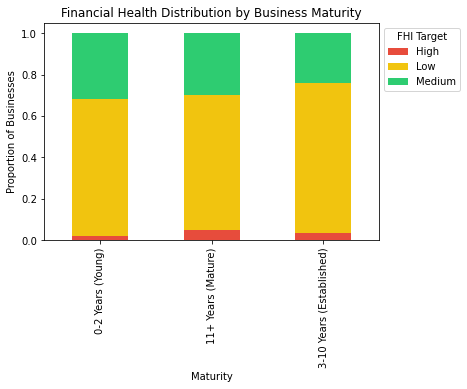

<Figure size 720x432 with 0 Axes>

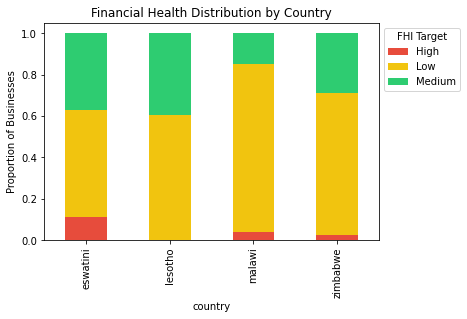

--- Maturity vs Target (%) ---
Target                    High    Low  Medium
Maturity                                     
0-2 Years (Young)         1.93  66.02   32.05
11+ Years (Mature)        5.06  64.85   30.09
3-10 Years (Established)  3.47  72.45   24.08

--- Country vs Target (%) ---
Target     High    Low  Medium
country                       
eswatini  11.48  51.42   37.10
lesotho    0.31  60.39   39.30
malawi     4.02  81.24   14.74
zimbabwe   2.34  68.57   29.10


In [252]:
# 1. Create a Maturity Feature
def categorize_maturity(years):
    if pd.isna(years): return 'Unknown'
    if years <= 2: return '0-2 Years (Young)'
    if years <= 10: return '3-10 Years (Established)'
    return '11+ Years (Mature)'



# If both are missing, the resulting 0 might be wrong, so let's keep NaNs as NaNs
train_data.loc[train_data['business_age_years'].isna() & train_data['business_age_months'].isna(), 'total_age_months'] = np.nan

# Combine years and months into a single continuous feature
train_data['total_age_months'] = (train_data['business_age_years'].fillna(0) * 12) + train_data['business_age_months'].fillna(0)

# If both are missing, the resulting 0 might be wrong, so let's keep NaNs as NaNs
test_data.loc[test_data['business_age_years'].isna() & test_data['business_age_months'].isna(), 'total_age_months'] = np.nan

# Combine years and months into a single continuous feature
test_data['total_age_months'] = (test_data['business_age_years'].fillna(0) * 12) + test_data['business_age_months'].fillna(0)

# Apply to your data
train_data['Maturity'] = train_data['total_age_months'].apply(categorize_maturity)
test_data['Maturity'] = test_data['total_age_months'].apply(categorize_maturity)

# 2. Relationship: Business Maturity vs Target (Normalized)
plt.figure(figsize=(10, 6))
maturity_dist = pd.crosstab(train_data['Maturity'], train_data['Target'], normalize='index')
maturity_dist.plot(kind='bar', stacked=True, color=['#e74c3c', '#f1c40f', '#2ecc71'])
plt.title('Financial Health Distribution by Business Maturity')
plt.ylabel('Proportion of Businesses')
plt.legend(title='FHI Target', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# 3. Relationship: Country vs Target (Normalized)
plt.figure(figsize=(10, 6))
country_dist = pd.crosstab(train_data['country'], train_data['Target'], normalize='index')
country_dist.plot(kind='bar', stacked=True, color=['#e74c3c', '#f1c40f', '#2ecc71'])
plt.title('Financial Health Distribution by Country')
plt.ylabel('Proportion of Businesses')
plt.legend(title='FHI Target', loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# 4. Statistical Summary
print("--- Maturity vs Target (%) ---")
print((maturity_dist * 100).round(2))
print("\n--- Country vs Target (%) ---")
print((country_dist * 100).round(2))

In [254]:

def create_maturity_and_context_features(df):
    df = df.copy()

    # 1. Consolidate Age into a single continuous feature
    # Use median for years and 0 for months to handle NaNs safely
    df['business_age_years'] = df['business_age_years'].fillna(df['business_age_years'].median())
    df['business_age_months_col'] = df['business_age_months'].fillna(0)
    
    # Total age in months
    df['total_business_age_months'] = (df['business_age_years'] * 12) + df['business_age_months_col']

    # 2. Add an "Owner Experience" Proxy
    # Calculate the ratio FIRST so the column exists
    # (Owner months / Business months) + 1 to avoid division by zero
    df['owner_age_to_business_age_ratio'] = (df['owner_age'] * 12) / (df['total_business_age_months'] + 1)

    # 3. NOW apply the Log transform to handle skews
    df['owner_age_to_business_age_ratio'] = np.log1p(df['owner_age_to_business_age_ratio'])

    # 4. Clean up temporary columns
    df = df.drop(columns=['business_age_months_col'])
    
    return df

# Apply to your sets
train_data = create_maturity_and_context_features(train_data)
test_data = create_maturity_and_context_features(test_data)

In [255]:
low = train_data[train_data['Target']== 'Low']['owner_age_to_business_age_ratio']
medium = train_data[train_data['Target']== 'Medium']['owner_age_to_business_age_ratio']
high = train_data[train_data['Target']== 'High']['owner_age_to_business_age_ratio']

f_stat, p_value = f_oneway(low, medium, high)

print("F-stat:", f_stat)
print("P-value:", p_value)

F-stat: 12.241380907585791
P-value: 4.9022212271002365e-06


### Feature importance

In [339]:
#Define X and y 
X = train_data.drop(columns=['Target', 'ID'])
y = train_data['Target']


# Change object data types to categorical
def change_object_to_cat(df):
  # changes objects columns to category and returns dataframe and list

  df = df.copy()
  list_str_obj_cols = df.columns[df.dtypes == "object"].tolist()
  for str_obj_col in list_str_obj_cols:
      df[str_obj_col] = df[str_obj_col].astype("category")

  return df,list_str_obj_cols
X, cat_list = change_object_to_cat(X)

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9618 entries, 0 to 9617
Data columns (total 37 columns):
 #   Column                                                            Non-Null Count  Dtype   
---  ------                                                            --------------  -----   
 0   country                                                           9618 non-null   category
 1   owner_age                                                         9618 non-null   float64 
 2   attitude_stable_business_environment                              9616 non-null   category
 3   attitude_worried_shutdown                                         9616 non-null   category
 4   compliance_income_tax                                             9614 non-null   category
 5   perception_insurance_doesnt_cover_losses                          9613 non-null   category
 6   perception_cannot_afford_insurance                                9613 non-null   category
 7   personal_income         

### Train-test split the data 

In [340]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=train_data[['country', 'Target']]
)

### Processing

In [341]:

# 1. Identify your columns
num_cols = X_train.select_dtypes(include=['float64']).columns
cat_cols = X_train.select_dtypes(include=['category']).columns

# 2. Define the Numerical Transformer
# Median is safer for financial data; Scaling is essential for most models
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 3. Define the Categorical Transformer
# handle_unknown='ignore' prevents the model from crashing if the test set 
# has a category the training set never saw.
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False)) 
])

# 4. Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ]
)

# 5. Fit and Transform X_train
# We "fit" only on train to avoid data leakage
X_train_processed = preprocessor.fit_transform(X_train)

# 6. Transform X_val
# We only "transform" the test set using the logic learned from train
X_val_processed = preprocessor.transform(X_val)

print(f"Original shape: {X_train.shape}")
print(f"Processed shape: {X_train_processed.shape}")

Original shape: (7694, 37)
Processed shape: (7694, 155)


In [192]:
# Fill based on country mode
train_data['owner_sex'] = train_data.groupby('country')['owner_sex'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "Unknown")
)

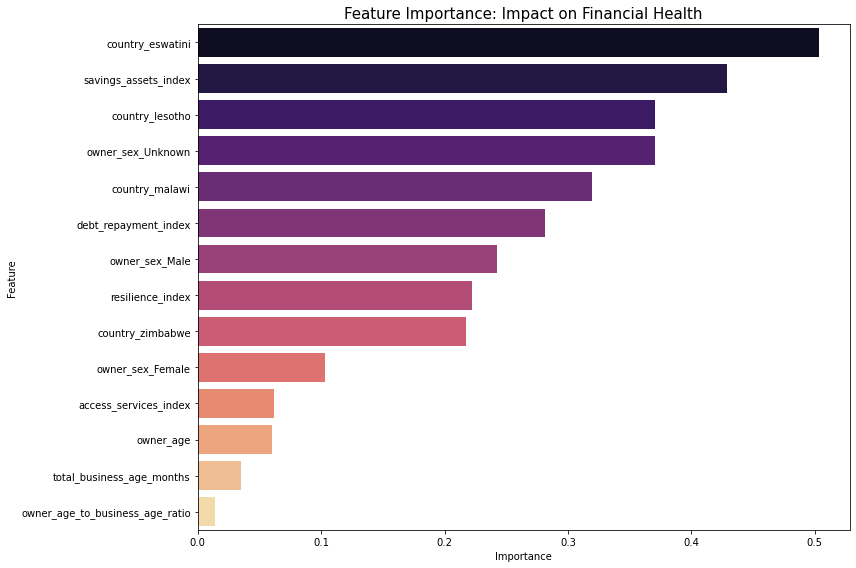

In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 1. Define the features we want to use (Raw + Your New Indices)
# We include the 4 indices, the new ratio, and key categorical variables
numeric_features = [
    'savings_assets_index', 'debt_repayment_index', 
    'resilience_index', 'access_services_index',
    'total_business_age_months', 'owner_age_to_business_age_ratio',
    'owner_age'
]

categorical_features = ['country', 'owner_sex']

# Create a small sub-pipeline for categories
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 2. Build the final Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', categorical_transformer, categorical_features) # Use the sub-pipeline here
    ])

# 3. Define the Model
# We use the winning baseline settings
final_model_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        multi_class='multinomial', 
        solver='saga', 
        max_iter=2000, 
        random_state=42
    ))
])

# 4. Fit the model on the engineered train_data
final_model_pipe.fit(train_data, train_data['Target'])

# 5. Extract Feature Importance (Coefficients)
# We get the feature names from the encoder for the plot labels
cat_step = final_model_pipe.named_steps['preprocessor'].transformers_[1][1]
cat_encoder = cat_step.named_steps['onehot']
#encoded_cat_names = cat_encoder.get_feature_names_out(categorical_features).tolist()
#all_feature_names = numeric_features + encoded_cat_names

# Version-proof way to get names
if hasattr(cat_encoder, 'get_feature_names_out'):
    encoded_cat_names = cat_encoder.get_feature_names_out(categorical_features).tolist()
else:
    encoded_cat_names = cat_encoder.get_feature_names(categorical_features).tolist()

all_feature_names = numeric_features + encoded_cat_names

# 5. Extract Feature Importance (Mean Absolute Coefficients)
coeffs = final_model_pipe.named_steps['classifier'].coef_
importance = np.mean(np.abs(coeffs), axis=0)

# Create the Plot
feat_importance = pd.DataFrame({'Feature': all_feature_names, 'Importance': importance})
feat_importance = feat_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feat_importance, palette='magma')
plt.title('Feature Importance: Impact on Financial Health', fontsize=15)
plt.tight_layout()
plt.show()

In [331]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [332]:
X_train_processed

array([[-1.10438409, -0.09529745, -0.07039212, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.55205015, -0.09672878, -0.07179428, ...,  0.        ,
         0.        ,  0.        ],
       [-1.40555395, -0.09672698, -0.07174104, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.02500289, -0.09666233, -0.07167004, ...,  0.        ,
         0.        ,  0.        ],
       [-0.95379916, -0.09529745, -0.07166412, ...,  0.        ,
         1.        ,  0.        ],
       [ 2.81082412, -0.09670902, -0.07179428, ...,  0.        ,
         0.        ,  0.        ]])

In [201]:
# 1. Define feature groups
# We include the 4 engineered indices, total_age_months, and the owner_experience_ratio
new_engineered_features = [
    'savings_assets_index', 'debt_repayment_index', 
    'resilience_index', 'access_services_index',
    'total_business_age_months', 'owner_age_to_business_age_ratio'
]

# Original numeric features
original_numeric = [
    'owner_age', 'business_expenses', 'business_turnover', 
    'business_age_years', 'personal_income'
]

# All categorical columns (excluding ID and Target)
categorical_features = [
    col for col in train_data.select_dtypes(include=['object']).columns 
    if col not in ['ID', 'Target', 'Maturity_Stage']
]

all_numeric = new_engineered_features + original_numeric


# 1. Numerical Transformer: Fill NaNs with Median, then Scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 2. Categorical Transformer: Fill NaNs with Mode, then One-Hot Encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 3. Combine into a Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, all_numeric),
        ('cat', categorical_transformer, categorical_features)
    ])

# 4. Create the Baseline Pipeline
baseline_full_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        multi_class='multinomial',
        solver='saga', 
        max_iter=2000,
        class_weight='balanced', 
        random_state=42
    ))
])

from sklearn.metrics import classification_report, log_loss

# Fit the model
baseline_full_model.fit(train_data, train_data['Target'])

# Predict on the training set to see the "Best Case" performance
train_preds = baseline_full_model.predict(train_data)
train_probs = baseline_full_model.predict_proba(train_data)

print("--- Final Baseline Classification Report ---")
print(classification_report(train_data['Target'], train_preds))

# Check Log Loss (The FHI competition metric)
print(f"Final Baseline Log Loss: {log_loss(train_data['Target'], train_probs):.4f}")



c:\Users\user\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


--- Final Baseline Classification Report ---
              precision    recall  f1-score   support

        High       0.15      0.79      0.25       470
         Low       0.81      0.52      0.63      6280
      Medium       0.39      0.43      0.41      2868

    accuracy                           0.50      9618
   macro avg       0.45      0.58      0.43      9618
weighted avg       0.65      0.50      0.55      9618

Final Baseline Log Loss: 0.9265


In [333]:
# Instantiate a LogisticRegression with random_state=42
baseline_model = LogisticRegression(multi_class='multinomial',
    random_state=42,
    C=1e5,
    solver='saga',
    max_iter=7000,
    penalty="elasticnet",
    class_weight='balanced',    
    l1_ratio=0.5)

# Use cross_val_score with scoring="neg_log_loss" to evaluate the model
# on X_train and y_train
baseline_neg_log_loss_cv = cross_val_score(baseline_model, X_train_processed, y_train, scoring="neg_log_loss")

baseline_log_loss = -(baseline_neg_log_loss_cv.mean())
baseline_log_loss

0.7095877611485479

In [ ]:
from sklearn.model_selection import GridSearchCV


param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],
    "l1_ratio": [0, 0.3, 0.5, 0.7, 1]
}

model = LogisticRegression(
    multi_class="multinomial",
    solver="saga",
    penalty="elasticnet",
    max_iter=8000,
    class_weight='balanced',
    random_state=42
)

grid = GridSearchCV(
    model,
    param_grid,
    scoring="neg_log_loss",
    cv=5,
    n_jobs=-1
)

grid.fit(X_train_processed, y_train)

print("Best params:", grid.best_params_)
print("Best log loss:", -grid.best_score_)




Best params: {'C': 1, 'l1_ratio': 1}
Best log loss: 0.5079720176693051


In [294]:

from sklearn.metrics import classification_report

# 1. Extract the best model from grid search
best_log_model = grid.best_estimator_

# 2. Make predictions using the processed training data
# We use X_train_processed because that's what the grid was fitted on
y_pred = best_log_model.predict(X_train_processed)

# 3. Print the report
print("--- Tuned Logistic Regression (ElasticNet) Report ---")
print(classification_report(y_train, y_pred))

# 4. Check the specific coefficients for the best model
print(f"Best Params: {grid.best_params_}")

--- Tuned Logistic Regression (ElasticNet) Report ---
              precision    recall  f1-score   support

        High       0.40      0.78      0.53       377
         Low       0.91      0.85      0.88      5024
      Medium       0.67      0.66      0.66      2293

    accuracy                           0.79      7694
   macro avg       0.66      0.76      0.69      7694
weighted avg       0.82      0.79      0.80      7694

Best Params: {'C': 1, 'l1_ratio': 1}


In [342]:
from sklearn.ensemble import RandomForestClassifier



# 1. Update the Pipeline with Random Forest

rf_model_pipe = Pipeline(steps=[

    ('preprocessor', preprocessor),

    ('classifier', RandomForestClassifier(

        n_estimators=200,

        max_depth=10, # Limiting depth to prevent overfitting the small 'High' class

        class_weight='balanced_subsample',

        random_state=42,

        n_jobs=-1

    ))

])

In [346]:

# 1. Prepare your features and target as DataFrames
X = train_data.drop(columns=['Target']) # This is a DataFrame with column names
y = train_data['Target']

# 2. Fit the pipeline using the DATAFRAME
# The pipeline will now find the strings 'savings_assets_index', etc.
rf_model_pipe.fit(X, y)

# 3. Evaluate using the same DataFrame
rf_preds = rf_model_pipe.predict(X)
rf_probs = rf_model_pipe.predict_proba(X)

print("--- Random Forest Classification Report ---")
print(classification_report(y, rf_preds))
# 3. Predict on test_data (which has 56 columns)
predictions = rf_model_pipe.predict(test_data)
predictions

--- Random Forest Classification Report ---
              precision    recall  f1-score   support

        High       0.84      0.94      0.89       470
         Low       0.94      0.89      0.92      6280
      Medium       0.78      0.85      0.81      2868

    accuracy                           0.88      9618
   macro avg       0.85      0.90      0.87      9618
weighted avg       0.89      0.88      0.88      9618



array(['Low', 'Medium', 'Low', ..., 'Medium', 'Medium', 'Low'],
      dtype=object)

In [304]:
rf_model_pipe.named_steps["classifier"].feature_importances_


array([1.95072403e-02, 3.33416852e-02, 3.09398509e-02, 3.53366156e-02,
       1.49774032e-02, 0.00000000e+00, 0.00000000e+00, 3.85658533e-03,
       0.00000000e+00, 1.08387863e-02, 0.00000000e+00, 2.29465742e-02,
       3.13457516e-03, 0.00000000e+00, 2.52804956e-02, 1.20045669e-02,
       3.99159269e-03, 4.95726861e-03, 6.04754219e-03, 2.04672110e-03,
       4.23402039e-06, 3.48031048e-03, 3.49195442e-03, 1.65636583e-03,
       3.66642158e-06, 3.85205695e-03, 4.23953209e-03, 1.42361502e-03,
       9.23039262e-06, 1.44154010e-02, 1.94910708e-05, 2.70734113e-02,
       3.14426830e-03, 2.28437886e-05, 4.22998132e-03, 3.50836000e-03,
       1.88355071e-03, 1.17516704e-05, 4.29427323e-03, 3.99326567e-03,
       1.95872870e-04, 1.25339622e-02, 1.16415525e-02, 8.61378763e-03,
       1.17125325e-03, 2.31108145e-05, 1.08541617e-02, 5.98883447e-03,
       4.34991823e-03, 1.75130725e-04, 3.19864606e-04, 2.03341349e-03,
       5.09715502e-03, 2.92997710e-03, 3.67466627e-03, 5.25918384e-03,
      

In [317]:
X_train_processed

array([[-1.10438409, -0.09529745, -0.07039212, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.55205015, -0.09672878, -0.07179428, ...,  0.        ,
         0.        ,  0.        ],
       [-1.40555395, -0.09672698, -0.07174104, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.02500289, -0.09666233, -0.07167004, ...,  0.        ,
         0.        ,  0.        ],
       [-0.95379916, -0.09529745, -0.07166412, ...,  0.        ,
         1.        ,  0.        ],
       [ 2.81082412, -0.09670902, -0.07179428, ...,  0.        ,
         0.        ,  0.        ]])

In [310]:
from sklearn.tree import DecisionTreeClassifier


# Instantiate and fit a DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(criterion='gini', max_depth=5) 
tree_clf.fit(X_train_processed, y_train)

DecisionTreeClassifier(max_depth=5)

In [311]:
# Feature importance
tree_clf.feature_importances_



array([0.00000000e+00, 4.11429041e-03, 4.26434101e-03, 1.37466639e-02,
       1.71063675e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.32622759e-04, 0.00000000e+00, 1.13448743e-03,
       2.29256780e-03, 0.00000000e+00, 4.18662444e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.84927639e-02, 0.00000000e+00, 7.08899767e-03,
       0.00000000e+00, 0.00000000e+00, 3.82454403e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

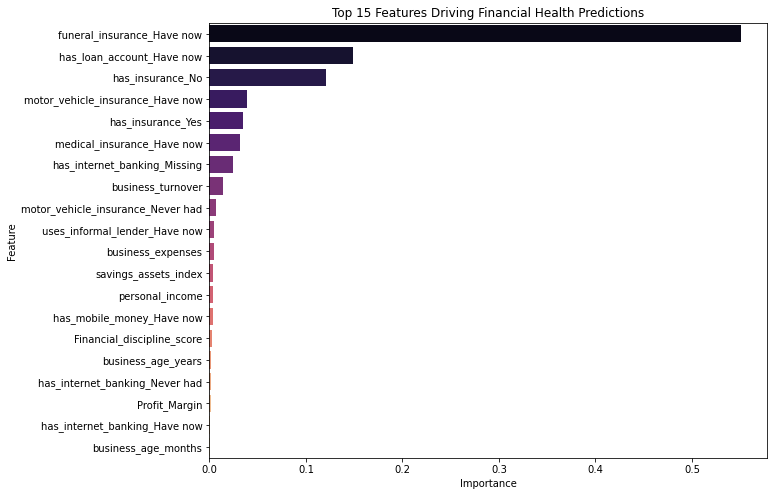

In [320]:
# 1. Dynamically extract ALL feature names from the preprocessor
def get_pipeline_feature_names(column_transformer):
    output_features = []
    
    for name, pipe, features in column_transformer.transformers_:
        if name == 'remainder' and pipe == 'drop':
            continue
        
        # If it's a pipeline (like our categorical one), get the last step
        if hasattr(pipe, 'steps'):
            transformer = pipe.steps[-1][1]
        else:
            transformer = pipe

        if hasattr(transformer, 'get_feature_names_out'):
            # Modern sklearn
            names = transformer.get_feature_names_out(features).tolist()
        elif hasattr(transformer, 'get_feature_names'):
            # Older sklearn
            names = transformer.get_feature_names(features).tolist()
        else:
            # For StandardScaler/SimpleImputer which don't change names
            names = features
            
        output_features.extend(names)
    return output_features

# 2. Get the real names
true_feature_names = get_pipeline_feature_names(rf_model_pipe.named_steps['preprocessor'])

# 3. Create the Plot
# Now they MUST be the same length (132 based on your array)
feat_imp_df = pd.DataFrame({
    'Feature': true_feature_names,
    'Importance': tree_clf.feature_importances_
})

feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feat_imp_df.head(20), x='Importance', y='Feature', palette='magma')
plt.title('Top 15 Features Driving Financial Health Predictions')
plt.show()

In [347]:
pred_df3 = pd.DataFrame({
    "ID": test_data["ID"],
    "Target": predictions
})


pred_df3.head(20)

,ID,Target
0,ID_5EGLKX,Low
1,ID_4AI7RE,Medium
2,ID_V9OB3M,Low
3,ID_6OI9DI,Low
4,ID_H2TN8B,Low
5,ID_U8T7ZQ,Medium
6,ID_QQJ3A1,Low
7,ID_F5S4JD,Low
8,ID_CY2C11,Medium
9,ID_63XVFI,Low


In [348]:
pred_df3.to_csv("submission4.csv", index=False)

In [223]:
# Check original file length (replace 'Test.csv' with your actual path)
original_test = pd.read_csv('Test.csv')
print(f"Original Test Rows: {len(original_test)}")
print(f"Your Prediction Rows: {len(pred_df)}")

Original Test Rows: 2405
Your Prediction Rows: 2405
